In [1]:
from data_mining import ImagePreProcessing
from data_visualization import SpikeViz
from spiking_neuron import Izhikevich

import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
num_neurons = 100
num_labels = 10
num_patterns = 50

ipp = ImagePreProcessing(dataset_patterns=x_train, 
                         dataset_labels=y_train,
                         patch_size=5,
                         patch_stride=1)
ipp.setMaxPatterns(val=num_patterns)
ipp.setMaxLabels(val=num_labels)

patches_per_label = ipp.run()
ipp.summary()

Dimensão (n x n) da imagem de entrada: n = 28
Dimensão (p x p) de cada patch(subset) da imagem: p = 5
Deslocamento da janela de extração de patches: 1
Quantidade de rótulos utilizados: 10
Quantidade de padrões utilizados: 50
Quantidade de patches extraídos por imagem: 529
Dimensão do conjunto de imagens, por rótulo: (10, 50, 28, 28)
Dimensões do conjunto de patches (Entrada para SNN): (10, 50, 529, 5, 5)


## Definição da camada de neurônios, pesos sinápticos e intensidade por patch:

In [4]:
patches_per_label.shape

(10, 50, 529, 5, 5)

In [5]:
W = np.random.uniform(0, 1, (num_labels, num_patterns, num_neurons, ipp.patches_ds.shape[2], ipp.patch_size, ipp.patch_size))

In [81]:
intensity_per_neuron = np.zeros((num_labels, num_patterns, num_neurons))
gama = 0.01

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            total_int = 0
            for patch in range(ipp.patches_ds.shape[2]):
                patch_int = 0
                for i in range(ipp.patch_size):
                    for j in range(ipp.patch_size):
                        patch_int += patches_per_label[label][pattern][patch][i][j]*W[label][pattern][neuron][patch][i][j]
                total_int += gama*patch_int
                patch_int = 0
            intensity_per_neuron[label][pattern][neuron] = total_int

## Converter as intensidades em correntes ao longo do tempo. Nesse caso, as correntes são constantes:

In [82]:
T = 100 
dt = 0.25
timeline = np.arange(0, T+dt, dt)
timeline.shape

(401,)

In [83]:
currents_per_neuron = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            for time_step in range(timeline.shape[0]):
                currents_per_neuron[label][pattern][neuron][time_step] = intensity_per_neuron[label][pattern][neuron]

## Instanciar uma camada de neurônios e aplicar a corrente em cada um:

In [84]:
neuron_layer = []
for i in range(num_neurons):
    neuron_layer.append(Izhikevich(neuron_type='RS'))

spike_train = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
spike_count = np.zeros((num_labels, num_patterns, num_neurons))
neurons_pot = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
spike_times = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            I = currents_per_neuron[label][pattern][neuron]
            sc = neuron_layer[neuron].spikeResponse(I, dt, 
                                                    spike_train[label][pattern][neuron], neurons_pot[label][pattern][neuron],
                                                    spike_times[label][pattern][neuron])
            spike_count[label][pattern][neuron] = sc
            neuron_layer[neuron].setNeuronBaseProperties()
    



## Visualização dos resultados: Contagem de spikes, Spike Train, Potencial

In [85]:
spkViz = SpikeViz(original_image=ipp.patlab_ds)

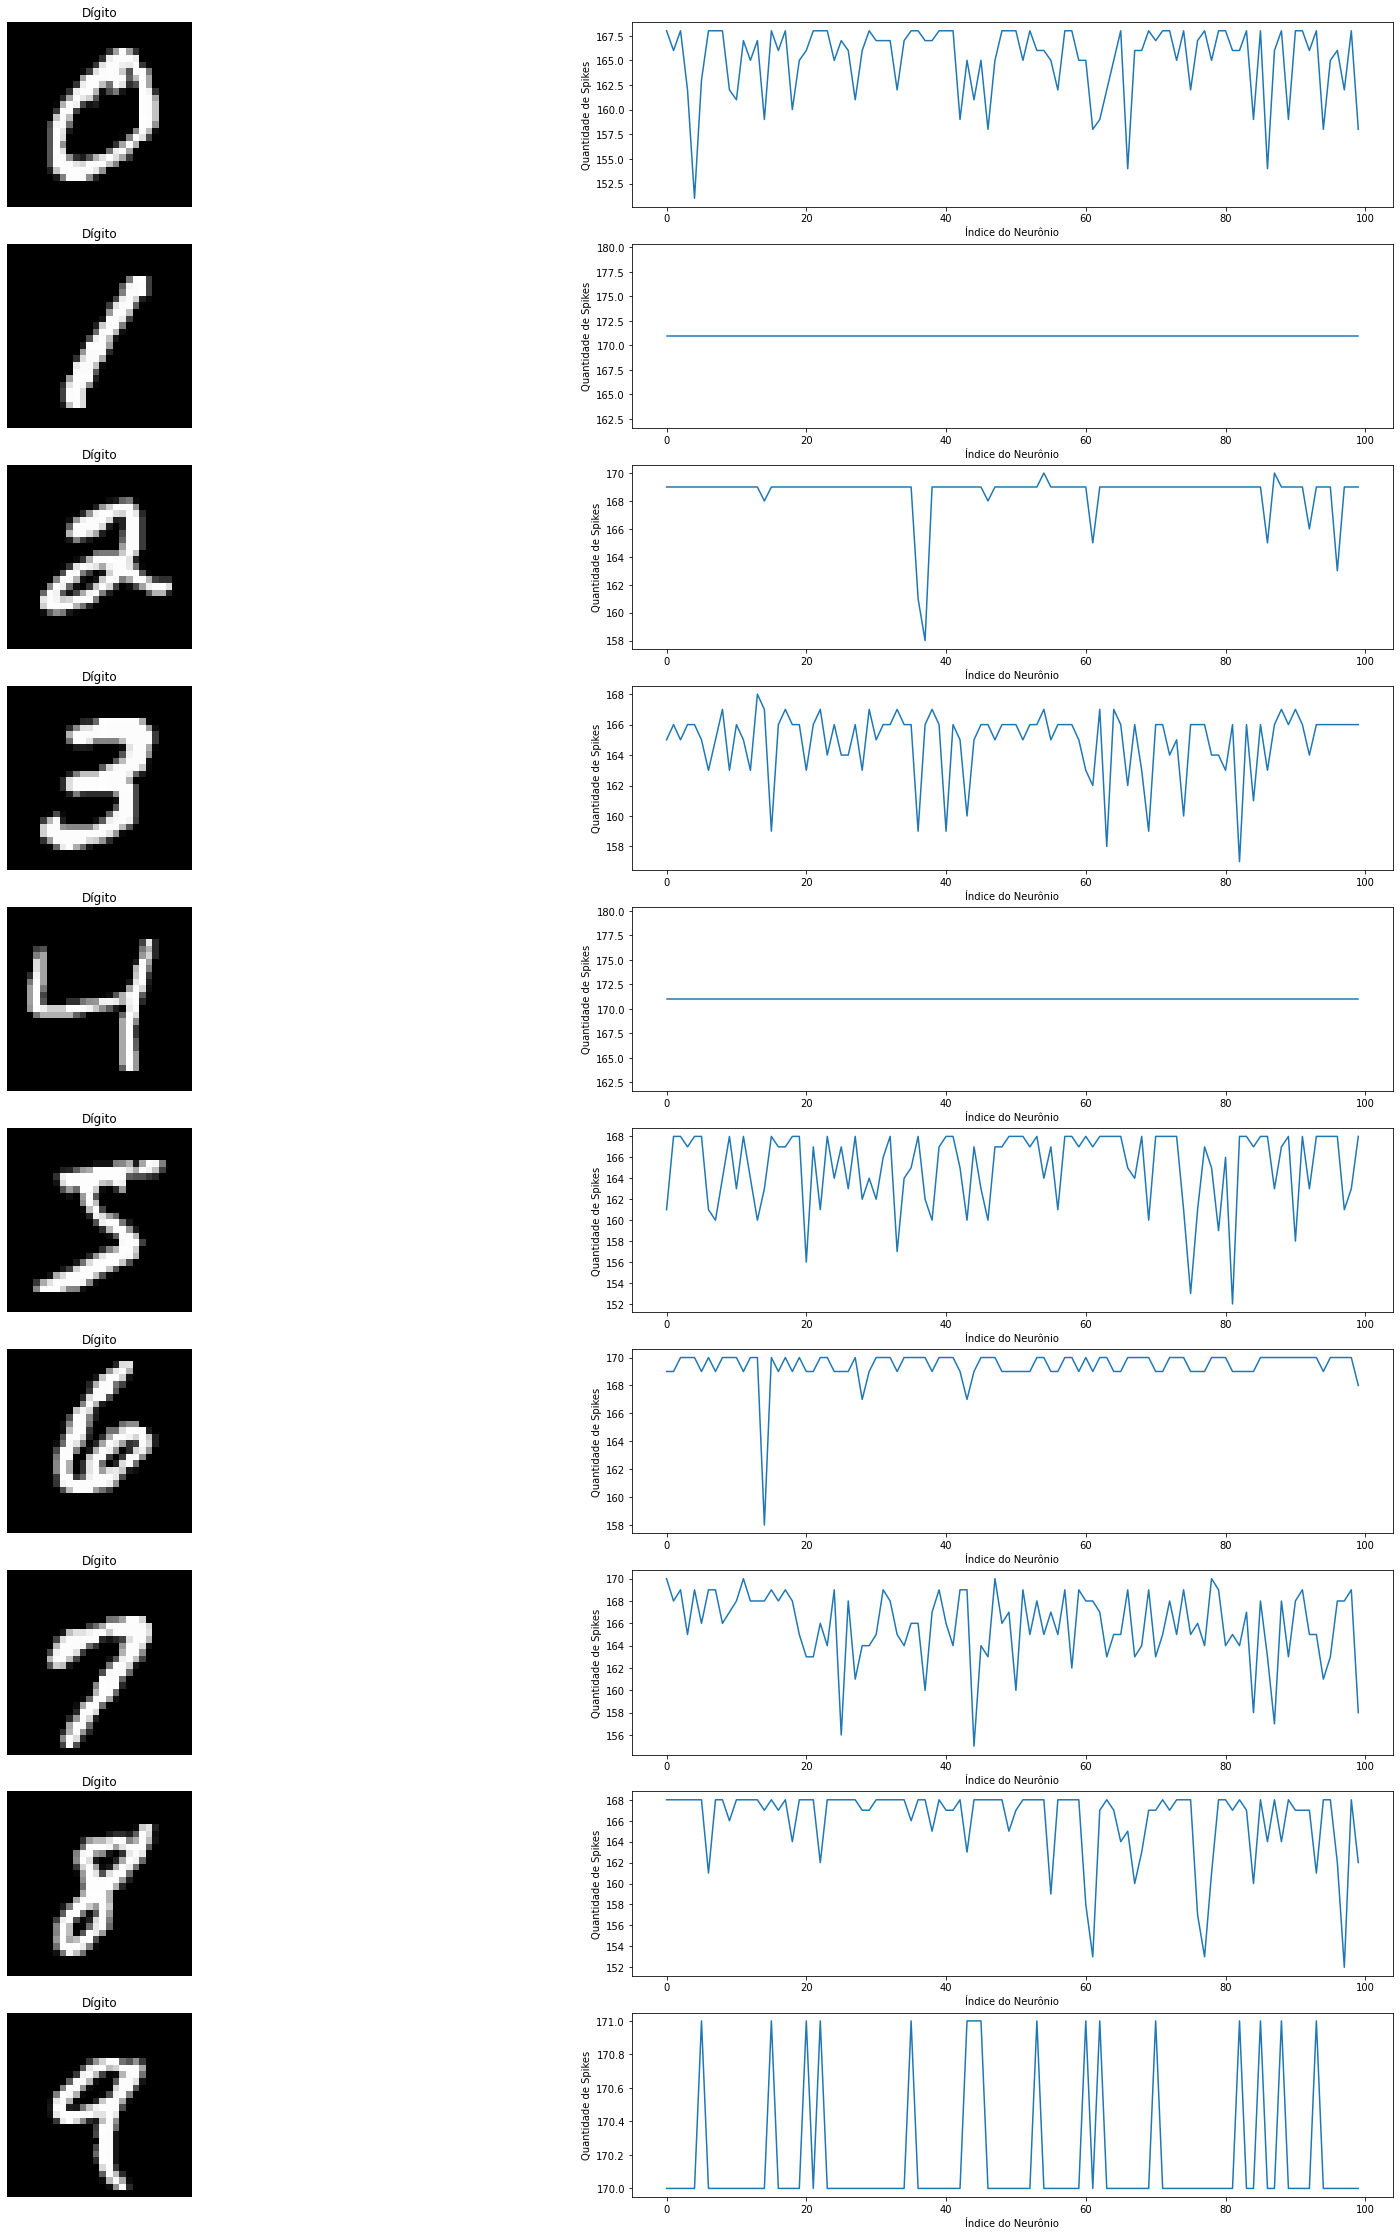

In [86]:
if (num_neurons == 1):
    spkViz.printSpikeViz(spike_obj=spike_count, 
                     x_label="Neurônio",
                     y_label="Quantidade de Spikes",
                     by_neuron=True, neuron_idx=0)
                    
else:
    spkViz.printSpikeViz(spike_obj=spike_count, 
                        x_label="Índice do Neurônio",
                        y_label="Quantidade de Spikes",
                        by_neuron=False )
                    

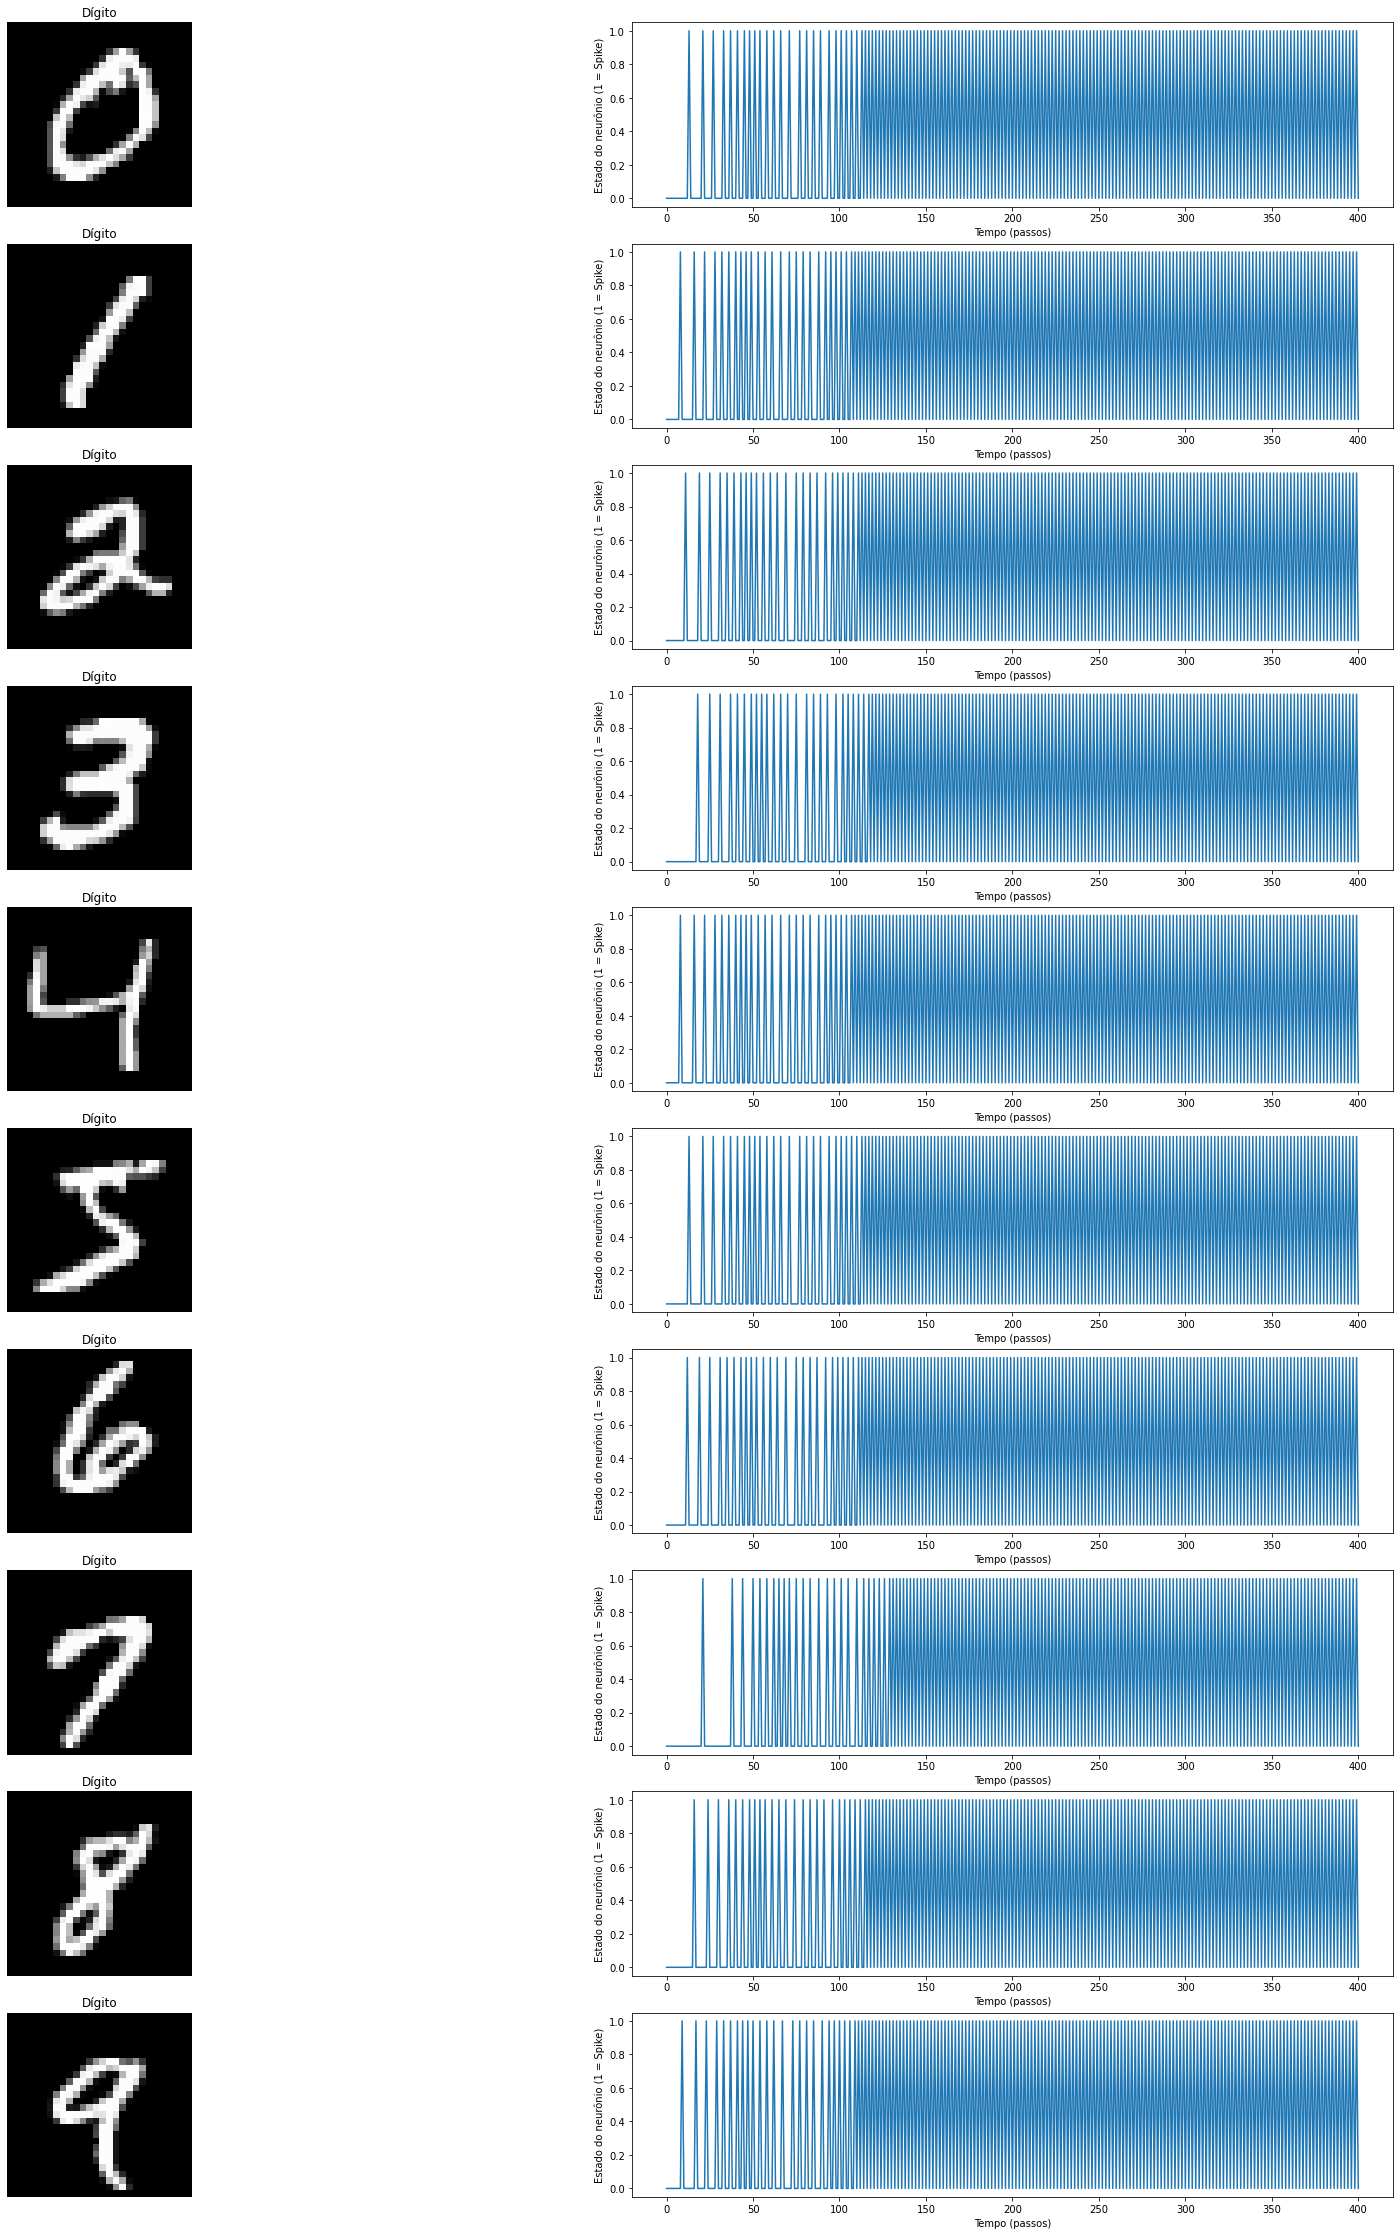

In [98]:
spkViz.printSpikeViz(spike_obj=spike_train, 
                     x_label="Tempo (passos)",
                     y_label="Estado do neurônio (1 = Spike)",
                     by_neuron= True,
                     neuron_idx = 50)

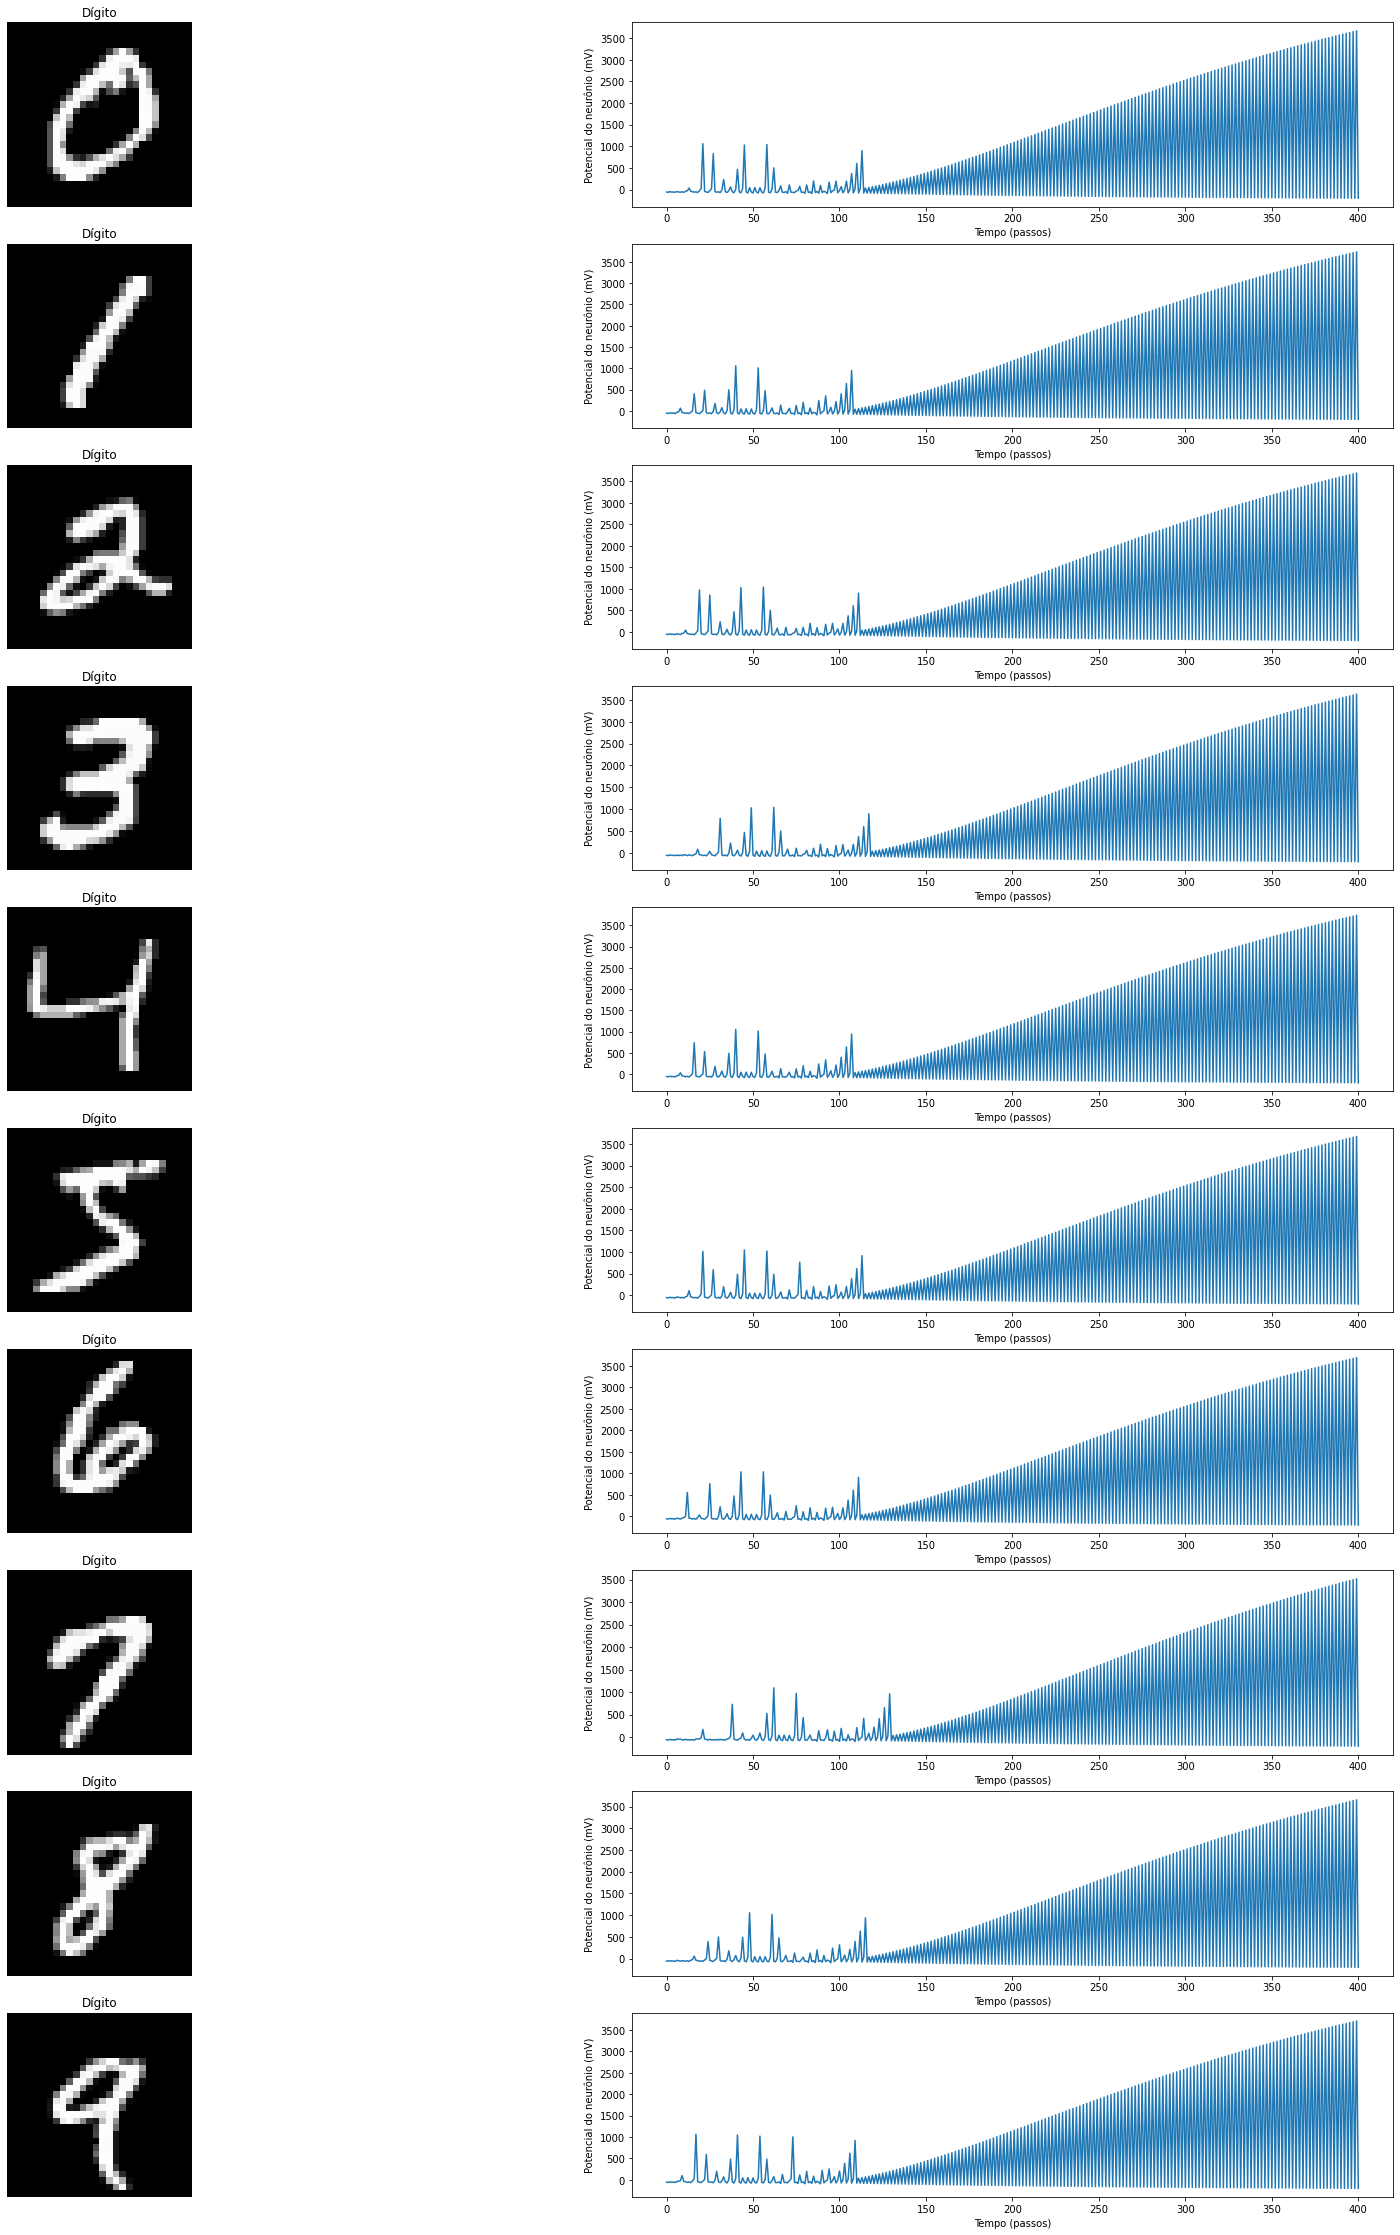

In [99]:
spkViz.printSpikeViz(spike_obj=neurons_pot, 
                     x_label="Tempo (passos)",
                     y_label="Potencial do neurônio (mV)",
                     by_neuron= True, 
                     neuron_idx = 50)

## Aplicação dos spikes como entrada de uma MLP com neurônios Preceptron.
## Será necessário juntar com os labels de cada dígito, assim como definir um spike train desejado para a rede neural.
## Uma forma de validar seu desempenho é comparando o treinamento de cada caso de Rede Neural.

In [89]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Para treinar os spikes codificados, é necessário quebrar o formato da base de saída para apresentar apenas a partir dos padrões(x_train) e os valores esperados dos labels(y_train).

In [90]:
spikes_y_train = []
for i in range(num_labels):
    for j in range(num_patterns):
        for k in range(num_neurons):
            spikes_y_train.append(i)
spikes_y_train = np.asarray(spikes_y_train)
spikes_y_train.shape

(50000,)

In [187]:
spikes_x_train = []
max_time = timeline.shape[0]
for i in range(num_labels):
    for j in range(num_patterns):
        for k in range(num_neurons):
            #spikes_x_train.append(spike_times[i][j][k]/max_time)
            spikes_x_train.append(spike_train[i][j][k])
spikes_x_train = np.asarray(spikes_x_train)
spikes_x_train.shape

(50000, 401)

In [222]:
from sklearn.model_selection import train_test_split

num_patterns = 50
num_classes = 10

x_train, x_test, y_train, y_test = train_test_split(spikes_x_train, spikes_y_train, test_size=0.2, random_state=66)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.models.Sequential()
#model.add(keras.layers.Dense(1000, input_dim=spike_train.shape[3],activation='sigmoid'))
model.add(keras.layers.Dense(spike_train.shape[0], input_dim=spike_train.shape[3], activation='softmax'))

batch_size = 64
epochs = 30
sgd = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/30
563/563 [==============================] - 1s 2ms/step - loss: 2.2631 - accuracy: 0.1517 - val_loss: 2.2030 - val_accuracy: 0.1947
Epoch 2/30
563/563 [==============================] - 1s 2ms/step - loss: 2.1790 - accuracy: 0.2002 - val_loss: 2.1633 - val_accuracy: 0.2090
Epoch 3/30
563/563 [==============================] - 1s 2ms/step - loss: 2.1466 - accuracy: 0.2117 - val_loss: 2.1362 - val_accuracy: 0.2170
Epoch 4/30
563/563 [==============================] - 1s 2ms/step - loss: 2.1260 - accuracy: 0.2179 - val_loss: 2.1170 - val_accuracy: 0.2272
Epoch 5/30
563/563 [==============================] - 1s 2ms/step - loss: 2.1103 - accuracy: 0.2236 - val_loss: 2.1015 - val_accuracy: 0.2113
Epoch 6/30
563/563 [==============================] - 1s 2ms/step - loss: 2.0982 - accuracy: 0.2286 - val_loss: 2.0932 - val_accuracy: 0.2288
Epoch 7/30
563/563 [==============================] - 1s 2ms/step - loss: 2.0869 - accuracy: 0.2341 - val_loss: 2.0849 - val_accuracy: 0.2300
Epoch 

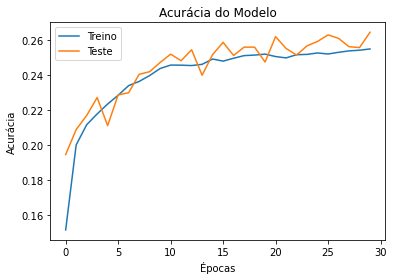

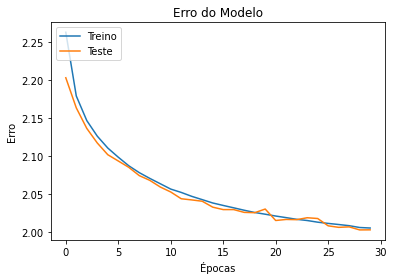

In [223]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [220]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.021625518798828
Test accuracy: 0.25


## Avaliação de desempenho utilizando validação cruzada, com k_folds =  30

In [204]:
from sklearn.model_selection import KFold
batch_size = 64
epochs = 30

kf = KFold(n_splits=5, shuffle=True)
kf_acc = []
kf_loss = []
for train_index, test_index in kf.split(spikes_x_train, spikes_y_train):
    x_train, x_test = spikes_x_train[train_index], spikes_x_train[test_index]
    y_train, y_test = spikes_y_train[train_index], spikes_y_train[test_index]
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(100, input_dim=spike_train.shape[3],activation='relu'))
    model.add(keras.layers.Dense(spike_train.shape[0], activation='softmax'))
    
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
    
    score = model.evaluate(x_test, y_test, verbose=0)
    kf_acc.append(score[1])
    kf_loss.append(score[0])
    print(f"Test loss: {score[0]} ### Test Accuracy: {score[1]}")

Test loss: 2.3236069679260254 ### Test Accuracy: 0.27149999141693115
Test loss: 2.546600818634033 ### Test Accuracy: 0.26089999079704285
Test loss: 2.5369930267333984 ### Test Accuracy: 0.24420000612735748
Test loss: 2.3364360332489014 ### Test Accuracy: 0.2533000111579895
Test loss: 2.544872283935547 ### Test Accuracy: 0.2556999921798706


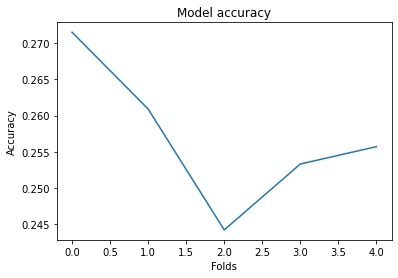

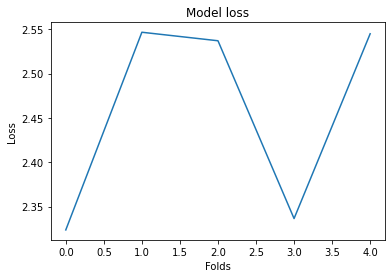

In [205]:
plt.plot(kf_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.show()

plt.plot(kf_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Folds')
plt.show()

In [206]:
import statistics

ma = statistics.mean(kf_acc)
me = statistics.mean(kf_loss)

print(f"Média da Acurácia: {ma}")
print(f"Média do Erro: {me}")

Média da Acurácia: 0.2571199983358383
Média do Erro: 2.457701826095581
